In [1]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cellnet

[notice] A new release of pip is available: 23.1.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


# Visualize training dynamics

In [1]:
import os
import re
from os.path import join

import tensorboard as tb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# logs under: https://tensorboard.dev/experiment/oYB2aPfzTQmXj07sJ7KOFg/
experiment_id = 'oYB2aPfzTQmXj07sJ7KOFg'
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()

In [3]:
LOGS_PATH = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default'

AUGMENTED = [f'augmentation=True_subset=30_run{i}' for i in range(1, 5)]
NON_AUGMENTED = [f'augmentation=False_subset=30_run{i}' for i in range(1, 5)]

In [4]:
def get_data(data, versions, columns):
    dfs = []
    for version in versions:
        if isinstance(version, str):
            version = [version]
        dfs.append(
            data[data.run.isin(version)]
            .drop_duplicates(subset=['step', 'tag'], keep='last')
            .pivot(index='step', columns='tag', values='value')
            [columns]
            .dropna()
            .assign(version=version[0])
        )
        
    return pd.concat(dfs)


val_cols = ['epoch', 'val_loss', 'val_f1_macro', 'val_f1_micro']
df_val_augmented = get_data(df, AUGMENTED, val_cols).assign(data_augmentation=True)
df_val_non_augmented = get_data(df, NON_AUGMENTED, val_cols).assign(data_augmentation=False)

train_cols = ['epoch', 'train_loss', 'train_f1_macro_step']
df_train_augmented = get_data(df, AUGMENTED, train_cols).assign(data_augmentation=True).reset_index()
df_train_non_augmented = get_data(df, NON_AUGMENTED, train_cols).assign(data_augmentation=False).reset_index()

In [5]:
def get_best_ckpts(logs_path, versions):
    epochs = []
    best_ckpts = []
    
    for version in versions:
        # sort first -> in case both f1-score are the same -> take the one which was trained for less epochs
        files = sorted([file for file in os.listdir(join(logs_path, version, 'checkpoints')) if 'val_f1_macro' in file])
        f1_scores = [float(re.search('val_f1_macro=(.*?).ckpt', file).group(1)) for file in files]
        best_ckpt = files[np.argmax(f1_scores)]
        epochs.append(int(re.search('epoch=(.*?)_val_f1_macro', best_ckpt).group(1)))
        best_ckpts.append(join(logs_path, version, 'checkpoints', best_ckpt))

    return best_ckpts, np.mean(epochs)


best_ckpts_augmented, avg_train_time_augmented = get_best_ckpts(LOGS_PATH, AUGMENTED)
best_ckpts_non_augmented, avg_train_time_non_augmented = get_best_ckpts(LOGS_PATH, NON_AUGMENTED)

#### Validation metrics

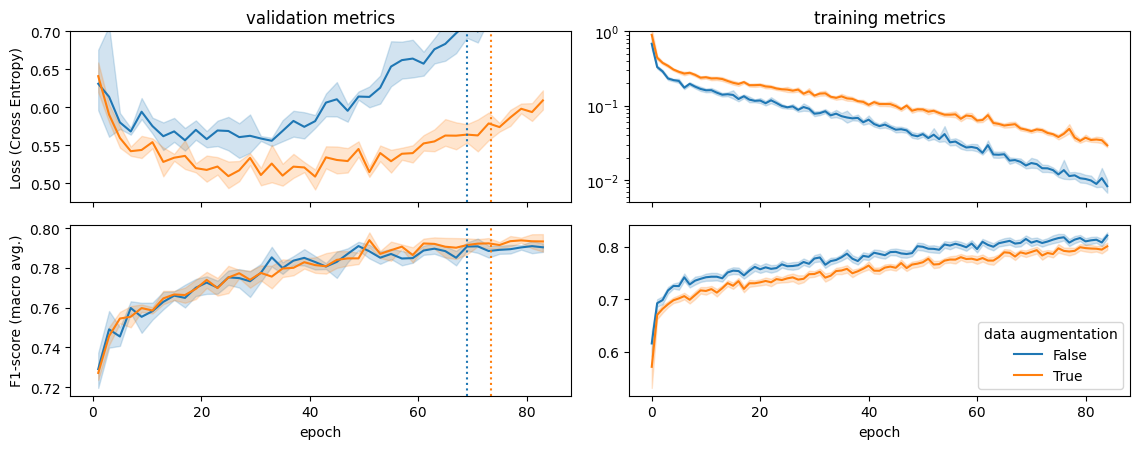

In [12]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(11.5, 4.6))

sns.lineplot(x='epoch', y='val_loss', hue='data_augmentation', data=pd.concat([df_val_augmented, df_val_non_augmented]), ax=axs[0, 0])
axs[0, 0].set_ylabel('Loss (Cross Entropy)')
axs[0, 0].set_ylim(0.475, 0.7)
axs[0, 0].axvline(avg_train_time_augmented, color='#ff7f0e', ls=':')
axs[0, 0].axvline(avg_train_time_non_augmented, color='#1f77b4', ls=':')
axs[0, 0].get_legend().remove()

sns.lineplot(x='epoch', y='val_f1_macro', hue='data_augmentation', data=pd.concat([df_val_augmented, df_val_non_augmented]), ax=axs[1, 0])
axs[1, 0].set_ylabel('F1-score (macro avg.)')
axs[1, 0].axvline(avg_train_time_augmented, color='#ff7f0e', ls=':')
axs[1, 0].axvline(avg_train_time_non_augmented, color='#1f77b4', ls=':')
axs[1, 0].get_legend().remove()


sns.lineplot(
    x='epoch', y='train_loss', hue='data_augmentation', 
    data=pd.concat([df_train_augmented, df_train_non_augmented]),
    ax=axs[0, 1]
)
axs[0, 1].set_ylabel('')
axs[0, 1].set_yscale('log')
axs[0, 1].set_ylim(5e-3, 1.)
axs[0, 1].get_legend().remove()

sns.lineplot(
    x='epoch', y='train_f1_macro_step', hue='data_augmentation', 
    data=pd.concat([df_train_augmented, df_train_non_augmented]), 
    ax=axs[1, 1]
)
axs[1, 1].set_ylabel('')
axs[1, 1].legend(title='data augmentation')

axs[0, 0].set_title('validation metrics')
axs[0, 1].set_title('training metrics')

plt.tight_layout()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure3/training-curves.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure3/training-curves.png', dpi=300)

# Evaluate performance

In [6]:
import torch
torch.set_float32_matmul_precision('high')

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from os.path import join

import numpy as np
import pandas as pd
import lightning.pytorch as pl
import dask.dataframe as dd

from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier

/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [8]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

In [ ]:
import gc


try:
    res_df = pd.read_csv('augmentation_results_subset.csv')
except FileNotFoundError:
    res_df = pd.DataFrame(
        {'test_loss': [], 'test_f1_macro': [], 'data_augmentation': [], 'ckpt': []}
    )


estim = EstimatorCellTypeClassifier(DATA_PATH)
estim.init_datamodule(batch_size=4096)
estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

results = {'test_loss': [], 'test_f1_macro': [], 'data_augmentation': [], 'ckpt': []}
for augment, ckpts in [(True, best_ckpts_augmented), (False, best_ckpts_non_augmented)]:
    for ckpt in ckpts:
        if ckpt in res_df.ckpt.tolist():
            run = res_df.ckpt == ckpt
            loss_ckpt = float(res_df.loc[run, 'test_f1_macro'])
            f1_ckpt = float(res_df.loc[run, 'test_f1_macro'])
            print(
                f"Reusing {ckpt.split('/')[-1]} checkpoint: f1-score={f1_ckpt:.4f} loss={loss_ckpt:.4f}"
            )
            results['test_loss'].append(loss_ckpt)
            results['test_f1_macro'].append(f1_ckpt)
            results['data_augmentation'].append(augment)
            results['ckpt'].append(ckpt)
        else:
            estim.model = TabnetClassifier.load_from_checkpoint(ckpt, **estim.get_fixed_model_params('tabnet'))
            res = estim.test()[0]
            results['test_loss'].append(res['test_loss'])
            results['test_f1_macro'].append(res['test_f1_macro'])
            results['data_augmentation'].append(augment)
            results['ckpt'].append(ckpt)
            gc.collect()


In [10]:
res_df = pd.DataFrame(results)
res_df.to_csv('augmentation_results_subset.csv')

#### Summary

In [11]:
from statistics import mean, stdev
from scipy.stats import ttest_ind

In [12]:
loss_augment = res_df[res_df.ckpt.isin(best_ckpts_augmented)]['test_loss'].tolist()
loss_non_augment = res_df[res_df.ckpt.isin(best_ckpts_non_augmented)]['test_loss'].tolist()
f1_augment = res_df[res_df.ckpt.isin(best_ckpts_augmented)]['test_f1_macro'].tolist()
f1_non_augment = res_df[res_df.ckpt.isin(best_ckpts_non_augmented)]['test_f1_macro'].tolist()

In [13]:
pd.DataFrame({
    'Neg. log-likelihood': [
        f"{mean(loss_augment):.3} +/- {stdev(loss_augment):.1}", 
        f"{mean(loss_non_augment):.3} +/- {stdev(loss_non_augment):.1}"
    ],
    'F1-score (macro avg.)': [
        f"{mean(f1_augment):.4} +/- {stdev(f1_augment):.1}",
        f"{mean(f1_non_augment):.4} +/- {stdev(f1_non_augment):.1}"
    ]
}, index=['w. augmentation', 'wo. augmentation'])

,Neg. log-likelihood,F1-score (macro avg.)
w. augmentation,0.659 +/- 0.04,0.7841 +/- 0.003
wo. augmentation,0.797 +/- 0.05,0.7755 +/- 0.002


In [14]:
from IPython.display import display
pd.options.display.float_format = None

In [15]:
pct_change_loss = 1. - mean(loss_non_augment) / mean(loss_augment)
pct_change_f1 = 1. - mean(f1_non_augment) / mean(f1_augment)


pd.DataFrame({
    'Neg. log-likelihood': [
        f'{pct_change_loss * 100.:.3}%',
        ttest_ind(loss_non_augment, loss_augment).pvalue,
        ttest_ind(loss_non_augment, loss_augment).pvalue <= 0.05
    ],
    'F1-score (macro avg.)': [
        f'{pct_change_f1 * 100.:.2}%',
        ttest_ind(f1_non_augment, f1_augment).pvalue,
        ttest_ind(f1_non_augment, f1_augment).pvalue <= 0.05
    ],
}, index=['percentage change', 'p value', 'significant'])

,Neg. log-likelihood,F1-score (macro avg.)
percentage change,-20.9%,1.1%
p value,0.00388,0.001615
significant,True,True
